# Topic Modelling

--------------------

* Topic Modelling is a technique to extract the hidden topics from large volumes of text.

* One of the important application of NLP is to extract what topics people are talking people are discussing from the large volumes of text

* **Latent Dirichlet Allocation (LDA)** is a popular algorithm for topic modelling in Python's **Gensim** package.

* **Challenge :** is how to extract good qaulity of topics that are *clear, segregated and meaningful* 
    - This is heavily depended on the **quality of text preprocessing** and the strategy of finding the **optimal number of topics**
    
Steps involved in topic modelling :
    
    1.Import the Packages
    2.Import the Dataset
    3.Remove unwanted characters, punctuations (eg., newline characters, emails etc)
    4.Tokenize words and clean up texts
    5.Creating Bigrams and Trigrams models
    6.Remove stowords and make bigrams and trigrams
    7.Lemmatization
    8.Create Dictionary and Corpus needed for LDA model
    9.Build the Topic Modelling
    10.View the topics in LDA model
    11.Compute the Model Perplexity and Coherence score
    12.Visualize the topic-keywords
    13.Find the optimal numbers for topics
    14.Find the dominant keyword for each sentence
    15.Find the most representative document for each topic
    16.Topic distribution across documents

In [1]:
# Import the Libraries and packages

import nltk
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spaCy for lemmatization
import spacy

# Plotting tools
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim

%matplotlib inline

# Enable logging for gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# For ignoring the warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Prepare the stopwords

from nltk.corpus import stopwords
all_stopwords = stopwords.words("english")
all_stopwords.extend(['from', 'subject', 're', 'edu', 'use'])

**Importing the Dataset**
We will be using the 20-Newsgroups dataset for this exercise. This version of the dataset contains about 11k newsgroups posts from 20 different topics. This is available as `newsgroups.json`

`newsgroups.json` : https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json

In [3]:
# Import the dataset
df = pd.read_json("https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json")

df.head()

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


In [4]:
# Check the unique topic names we have in the dataset
print(df.target_names.unique())

# Get the count of each topic names
df.target_names.value_counts()

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


target_names
rec.sport.hockey            600
soc.religion.christian      599
rec.motorcycles             598
rec.sport.baseball          597
sci.crypt                   595
rec.autos                   594
sci.med                     594
comp.windows.x              593
sci.space                   593
comp.os.ms-windows.misc     591
sci.electronics             591
comp.sys.ibm.pc.hardware    590
misc.forsale                585
comp.graphics               584
comp.sys.mac.hardware       578
talk.politics.mideast       564
talk.politics.guns          546
alt.atheism                 480
talk.politics.misc          465
talk.religion.misc          377
Name: count, dtype: int64

As you can see that so many emails, newline and extra spaces which is quite distracting. Lets remove them using **python regex**

In [5]:
# Conver the content into list
data = df.content.values.tolist()

# Print 1st row content before removing
print("Before processing : \n")
pprint(data[0:1])

# Remove the emails
data = [re.sub('\S*@\S*\s?', ' ', sent) for sent in data]

# Remove the newline characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove the distracting single quotes
data = [re.sub("\'", ' ', sent) for sent in data]

# Print the 1st row content after removing some items
print("\nAfter processing : \n")
pprint(data[0:1])

Before processing : 

["From: lerxst@wam.umd.edu (where's my thing)\n"
 'Subject: WHAT car is this!?\n'
 'Nntp-Posting-Host: rac3.wam.umd.edu\n'
 'Organization: University of Maryland, College Park\n'
 'Lines: 15\n'
 '\n'
 ' I was wondering if anyone out there could enlighten me on this car I saw\n'
 'the other day. It was a 2-door sports car, looked to be from the late 60s/\n'
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition,\n'
 'the front bumper was separate from the rest of the body. This is \n'
 'all I know. If anyone can tellme a model name, engine specs, years\n'
 'of production, where this car is made, history, or whatever info you\n'
 'have on this funky looking car, please e-mail.\n'
 '\n'
 'Thanks,\n'
 '- IL\n'
 '   ---- brought to you by your neighborhood Lerxst ----\n'
 '\n'
 '\n'
 '\n'
 '\n']

After processing : 

['From: (where s my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Ma

**Tokenize words and clean up text**

Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.

Gensim’s `simple_preprocess()` is great for this. Additionally I have set `deacc=True` to remove the punctuations.

In [6]:
def senToWords(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
data_words = list(senToWords(data))

# Print the 1st content words
print(data_words[:1])

[['from', 'where', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


**Creating Bigram and Trigram Models**

Gensim’s `Phrases` model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to `Phrases` are `min_count` and `threshold`. The **higher the values of these param, the harder it is for words to be combined to bigrams**.

`min_count` : Ignore all words and bigrams with total collected count lower than this value

`threshold` :  Represent a score threshold for forming the phrases (higher means fewer phrases).
    A phrase of words `a` followed by `b` is accepted if the score of the phrase is greater than threshold.

In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # Higher Threshold values fewer phrases
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get sentence clubbed as a bigram/trigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See the xapmles of trigrasm
print(trigram_mod[bigram_mod[data_words[0]]])

['from', 'where', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


In [8]:
# See the example of bigrams
print(bigram_mod[data_words[0]])

['from', 'where', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting', 'host', 'rac_wam', 'umd_edu', 'organization', 'university', 'of', 'maryland_college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


**What's happening above ?**

`bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)`: This line creates a **bigram model** using `gensim.models.Phrases`. 

`trigram = gensim.models.Phrases(bigram[data_words], threshold=100)`: This line creates a **trigram model from the bigrams** obtained in the previous step. 

`bigram_mod = gensim.models.phrases.Phraser(bigram)`: This line creates a `Phraser` object for the bigram model. `Phraser` is a faster way to get a sentence clubbed as a bigram.

`trigram_mod = gensim.models.phrases.Phraser(trigram)`: Similarly, this line creates a `Phraser` object for the trigram model.

Now, `bigram_mod` and `trigram_mod` will be ready to use for **transforming your text data into bigram and trigram phrases**, respectively.

**Remove the Stopwords, Make Bigrams & Trigrams and Lemmatization**

In [9]:
# Define individual functions to perform these tasks

# Remove stopwords
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in all_stopwords] for doc in texts]

# Make Bigrams using the 'bigram_mod'
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# Make Trigrams using the 'trigram_mod'
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts] # This is because, we always use bigrams to make trigrams. We add words to bigrams

# Lemmatization -> We use spaCy for this
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Lets call the above defined fucntions in order to process the text

# Remove stopwords
data_without_stopwords = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_without_stopwords)

# Initiallize the spacy with 'en' model
# !python -m spacy download en_core_web_sm -> To download if the model not found error pops up
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

# Lemmatize the words
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['thing', 'car', 'nntp_poste', 'host', 'rac_wam', 'university', 'park', 'line', 'wonder', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'door', 'really', 'small', 'addition', 'separate', 'rest', 'body', 'know', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


Now create a **dictionary** and **corpus** needed for the topic modelling

The two main inputs for the **LLD** model is dictionary `id2word` and the corpus

In [11]:
# Creating the 'id2word' dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create corpus
texts = data_lemmatized

# Create 'term-document' frequency
docterm = [id2word.doc2bow(text) for text in texts]

print(docterm[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 5), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1)]]


Gensim creates a unique **id** for each word.

The above 'docterm' shows the `(word_id, word_frequency)`

If you want to see the human readable docterm, then :

In [12]:
[[(id2word[id], freq) for id, freq in cp] for cp in docterm[:1]]

# for cp in docterm[:1] -> Each tuple
# for id, freq in cp -> (word_is, word_frequency) from each tuple
# (id2word[id], freq) -> (word, frequency)

[[('addition', 1),
  ('body', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 5),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('info', 1),
  ('know', 1),
  ('late', 1),
  ('lerxst', 1),
  ('line', 1),
  ('look', 2),
  ('mail', 1),
  ('make', 1),
  ('model', 1),
  ('name', 1),
  ('neighborhood', 1),
  ('nntp_poste', 1),
  ('park', 1),
  ('production', 1),
  ('rac_wam', 1),
  ('really', 1),
  ('rest', 1),
  ('see', 1),
  ('separate', 1),
  ('small', 1),
  ('spec', 1),
  ('sport', 1),
  ('thank', 1),
  ('thing', 1),
  ('university', 1),
  ('wonder', 1),
  ('year', 1)]]

**Building the topic model**

Apart from the dictionay and corpus, you need to pass the `number_of_topics`.

`alpha` and `eta` affects the sparsity of the topics

`chunksize` is the number of documents to be used in each training chunk

`update_every` determines how often the model parameters should be updated

`passes` is the number training passes

In [13]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=docterm,
                                           id2word=id2word,
                                           num_topics = 20,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

**View the topics in LDA Model**

The above LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes a certain weigthage to the topic

`lda_model.print_topics()` : Keywords for each topic and weightage(importance) for each keyword

In [14]:
pprint(lda_model.print_topics())

# This gives the top 10 keywords for each topic and their importance 

[(0,
  '0.036*"key" + 0.026*"system" + 0.017*"win" + 0.017*"technology" + '
  '0.017*"sale" + 0.014*"chip" + 0.014*"player" + 0.013*"phone" + '
  '0.012*"public" + 0.012*"discussion"'),
 (1,
  '0.018*"say" + 0.016*"make" + 0.016*"think" + 0.015*"go" + 0.014*"people" + '
  '0.013*"see" + 0.013*"know" + 0.012*"time" + 0.011*"well" + 0.010*"come"'),
 (2,
  '0.142*"file" + 0.061*"entry" + 0.048*"pin" + 0.041*"section" + '
  '0.031*"notice" + 0.029*"internal" + 0.025*"external" + 0.023*"fix" + '
  '0.022*"processor" + 0.022*"doctor"'),
 (3,
  '0.113*"image" + 0.044*"motif" + 0.044*"object" + 0.033*"boy" + 0.028*"link" '
  '+ 0.026*"workstation" + 0.025*"helmet" + 0.023*"mit" + 0.021*"laboratory" + '
  '0.021*"picture"'),
 (4,
  '0.068*"season" + 0.057*"goal" + 0.051*"trade" + 0.050*"nhl" + 0.047*"fan" + '
  '0.037*"pen" + 0.034*"star" + 0.022*"cap" + 0.021*"planet" + 0.019*"final"'),
 (5,
  '0.087*"line" + 0.053*"write" + 0.048*"organization" + 0.043*"article" + '
  '0.034*"nntp_poste" + 0.

In [15]:
doc_lda = lda_model[docterm]

**Compute Model Perplexity and Coherence Score**

This provide a convenient measure to judge how good a given topic model is.

**Lower the perplexity, better the model**

**Higher the Coherence, better the model**

In [16]:
# Compute the Perplexity
print("perplexity : ", lda_model.log_perplexity(docterm))

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print("Coherence : ", coherence_lda)

perplexity :  -13.279670042044604
Coherence :  0.5072901564761652


**Visualize Topic-Keywords**



In [17]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, docterm, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.352573 -0.024495       1        1  39.132662
5     -0.306664  0.179803       2        1  15.580029
16    -0.301671  0.087236       3        1  13.026129
0     -0.173894  0.053334       4        1   6.318405
15     0.020328 -0.016045       5        1   5.325798
6     -0.161562 -0.159654       6        1   4.054201
13    -0.113752 -0.283817       7        1   3.731307
19    -0.086560  0.176792       8        1   2.846544
10    -0.042376 -0.252236       9        1   2.305566
2      0.090290  0.010097      10        1   1.334886
14     0.083808  0.067259      11        1   1.065440
8      0.094005  0.015691      12        1   0.978454
7      0.086885  0.042419      13        1   0.913052
3      0.148908  0.012771      14        1   0.793708
4      0.131132  0.021420      15        1   0.701077
9      0.150365  0.004813      16        1   0.545160
12     0.164571  0.019252      17        1   0.531235
17     0.173168  0.013312      18        1   0.447343
11     0.195013  0.016091      19        1   0.211427
18     0.200576  0.015957      20        1   0.157578, topic_info=               Term          Freq         Total Category  logprob  loglift
4364             ax  53102.000000  53102.000000  Default  30.0000  30.0000
17             line  17239.000000  17239.000000  Default  29.0000  29.0000
39             year   4826.000000   4826.000000  Default  28.0000  28.0000
204           write  13573.000000  13573.000000  Default  27.0000  27.0000
139    organization   9501.000000   9501.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
4829       keyboard      0.027899      1.280792  Topic20 -11.1844   2.6264
47196        caviar      0.027898      1.280763  Topic20 -11.1845   2.6264
17530       neutral      0.027899      1.280776  Topic20 -11.1844   2.6264
5125     connection      0.027899      1.280808  Topic20 -11.1844   2.6263
5196        install      0.027899      1.280799  Topic20 -11.1844   2.6263

[861 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
488       6  0.992580      absolute
40       13  0.974040  acceleration
1339      1  0.476493        accept
1339      6  0.521780        accept
331      19  0.914670  accidentally
...     ...       ...           ...
204       6  0.000884         write
469       1  0.999484         wrong
39        1  0.832020          year
39        3  0.003108          year
39       13  0.164705          year

[1073 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 17, 1, 16, 7, 14, 20, 11, 3, 15, 9, 8, 4, 5, 10, 13, 18, 12, 19])

**So how to infer pyLDAvis’s output?**

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

In [19]:
pprint(lda_model.show_topics(formatted=False))

[(18,
  [('review', 0.11047579),
   ('cable', 0.07105691),
   ('connector', 0.036692955),
   ('compression', 0.031561323),
   ('meter', 0.02136887),
   ('tour', 0.017826892),
   ('compress', 0.013841126),
   ('assemble', 0.012456554),
   ('cord', 0.0071357153),
   ('australian', 0.0053294683)]),
 (15,
  [('ax', 0.78215164),
   ('max', 0.053083137),
   ('saturn', 0.0076002683),
   ('quick', 0.0072289505),
   ('warn', 0.0070287003),
   ('trace', 0.0054797037),
   ('curious', 0.004662206),
   ('strip', 0.0036895084),
   ('correction', 0.003603074),
   ('belt', 0.003347158)]),
 (11,
  [('advance', 0.13712394),
   ('brain', 0.10405214),
   ('usenet', 0.039007645),
   ('suitable', 0.020558525),
   ('bolt', 0.01695665),
   ('tight', 0.016354507),
   ('ins_cwru', 0.015751367),
   ('stadium', 0.010252855),
   ('valve', 0.009787368),
   ('western_digital', 0.008503102)]),
 (17,
  [('hot', 0.04515221),
   ('cycle', 0.038184255),
   ('mirror', 0.0347789),
   ('water', 0.03175441),
   ('oil', 0.030

**Finding the optimal number for Topics**

* Build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.
* Choosing a **k** that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.
* If you see the **same keywords** being repeated in **multiple topics**, it’s probably a sign that the **‘k’ is too large**.
* The `compute_coherence_values()` (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

In [20]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics
    start : Starting number of topics
    step : How many number of topics to add for the next iteration 

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherence_model = CoherenceModel(model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
        

    return model_list, coherence_values

In [21]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=docterm, texts=data_lemmatized, limit=40, start=2, step=6)

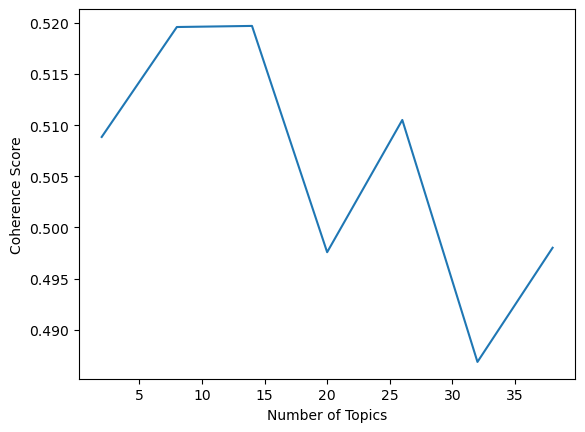

In [22]:
# Plot the above values

limit=40; start=2; step=6;

x = range(start, limit, step)

plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")

plt.show()

In [24]:
# Print the coherence score and the number of topics

for t, cs in zip(x, coherence_values):
    print(f"Number of topics : {t}\thas Coherence Score : {round(cs,4)}\n")

Number of topics : 2	has Coherence Score : 0.5088

Number of topics : 8	has Coherence Score : 0.5196

Number of topics : 14	has Coherence Score : 0.5197

Number of topics : 20	has Coherence Score : 0.4976

Number of topics : 26	has Coherence Score : 0.5105

Number of topics : 32	has Coherence Score : 0.4868

Number of topics : 38	has Coherence Score : 0.498



From the above graph and the coherence score, we can conclude that the model with **14** topics as highest coherence score, which makes a better model. So lets choose the model with *14 number of topics*

In [25]:
optimal_model = model_list[2]

model_topics = optimal_model.show_topics(formatted=False)

pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.018*"key" + 0.008*"space" + 0.007*"information" + 0.007*"encryption" + '
  '0.007*"system" + 0.007*"use" + 0.006*"public" + 0.005*"security" + '
  '0.005*"datum" + 0.005*"file"'),
 (1,
  '0.016*"line" + 0.015*"get" + 0.012*"write" + 0.009*"article" + '
  '0.008*"organization" + 0.007*"know" + 0.006*"nntp_poste" + 0.006*"go" + '
  '0.006*"host" + 0.006*"want"'),
 (2,
  '0.012*"write" + 0.011*"line" + 0.009*"article" + 0.007*"think" + '
  '0.006*"organization" + 0.006*"say" + 0.006*"make" + 0.006*"nntp_poste" + '
  '0.005*"system" + 0.005*"well"'),
 (3,
  '0.014*"armenian" + 0.010*"turk" + 0.008*"people" + 0.008*"turkish" + '
  '0.008*"israeli" + 0.006*"greek" + 0.006*"arab" + 0.006*"line" + '
  '0.006*"write" + 0.005*"government"'),
 (4,
  '0.010*"line" + 0.009*"get" + 0.008*"go" + 0.008*"gun" + 0.007*"write" + '
  '0.007*"right" + 0.006*"people" + 0.006*"make" + 0.006*"year" + '
  '0.006*"ripem"'),
 (5,
  '0.014*"write" + 0.013*"say" + 0.010*"article" + 0.009*"line" + '
  '0.

**Finding the Dominant Topic in each Sentence**

* To find that, we find the **topic number that has the highest percentage contribution** in that document.
* The `format_topics_sentences()` function below nicely aggregates this information in a presentable table.

In [45]:
def format_topics_sentences(ldamodel=lda_model, corpus=docterm, texts=data):
    
    # Init output
    sent_topics_df = pd.DataFrame(columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])
    
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df.loc[i] = [int(topic_num), round(prop_topic,4), topic_keywords]
                break
    
    # Add original text to the end of the output
    sent_topics_df['Text'] = pd.Series(texts)
    
    return sent_topics_df


In [46]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=docterm, texts=data)

In [49]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7,0.7627,"line, organization, use, get, drive, nntp_post...",From: (where s my thing) Subject: WHAT car is ...
1,1,7,0.9114,"line, organization, use, get, drive, nntp_post...",From: (Guy Kuo) Subject: SI Clock Poll - Final...
2,2,1,0.7150,"line, get, write, article, organization, know,...",From: (Thomas E Willis) Subject: PB questions....
3,3,1,0.5781,"line, get, write, article, organization, know,...",From: (Joe Green) Subject: Re: Weitek P9000 ? ...
4,4,1,0.4902,"line, get, write, article, organization, know,...",From: (Jonathan McDowell) Subject: Re: Shuttle...
5,5,4,0.6382,"line, get, go, gun, write, right, people, make...",From: (Foxvog Douglas) Subject: Re: Rewording ...
6,6,12,0.4487,"team, game, line, year, write, player, play, g...",From: (brian manning delaney) Subject: Brain T...
7,7,7,0.8887,"line, organization, use, get, drive, nntp_post...",From: (GRUBB) Subject: Re: IDE vs SCSI Organiz...
8,8,7,0.9558,"line, organization, use, get, drive, nntp_post...",From: Subject: WIn 3.0 ICON HELP PLEASE! Organ...
9,9,7,0.9803,"line, organization, use, get, drive, nntp_post...",From: (Stan Kerr) Subject: Re: Sigma Designs D...


**Find the most representative document for each topic**

* Sometimes just the topic keywords may not be enough to make sense of what a topic is about. 
* So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document

In [51]:
# Group top 5 sentences under each topic
sent_topics_sorted = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorted = pd.concat([sent_topics_sorted, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorted.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorted.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorted

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0,0.9979,"key, space, information, encryption, system, u...",From: Danny Weitzner Subject: Re-inventing Cry...
1,1,0.9932,"line, get, write, article, organization, know,...",From: (Gordon Hamachi) Subject: Re: Honda Acco...
2,2,0.9959,"write, line, article, think, organization, say...",From: (Keith Allan Schneider) Subject: Re: <Po...
3,3,0.9944,"armenian, turk, people, turkish, israeli, gree...",From: (Serdar Argic) Subject: As today marks t...
4,4,0.9927,"line, get, go, gun, write, right, people, make...",From: (Tom Smith) Subject: Re: Clinton wants N...
5,5,0.9952,"write, say, article, line, people, believe, th...",From: (Carol Alvin) Subject: Re: The arrogance...
6,6,0.9908,"window, line, file, write, server, system, pro...",From: Subject: Re: Xt intrinsics: slow popups ...
7,7,0.9949,"line, organization, use, get, drive, nntp_post...",From: (Fred G Martin) Subject: Re: Put ex. syq...
8,8,0.9925,"system, line, get, say, go, drive, write, work...",From: (Yousuf Khan) Subject: Re: IDE vs SCSI (...
9,9,0.9893,"line, write, get, nntp_poste, host, organizati...",From: A. Charles Gross Subject: I have seen th...


* The above output has 14 rows representing 14 topics.
* It has topic number, keywords, and the most representative document. 
* The `Perc_Contribution` column is nothing but the percentage contribution of the topic in the given document.